### Monte carlo simulation to aggregate at the goal level


In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [65]:
indicators = pd.read_csv("../output/indicators.csv", index_col=0)
indicators.set_index(["Country", "Year"], inplace=True)
indicators = indicators[[i for i in indicators if i.startswith("14")]]
indicators

14.1       14.3       14.5       14.7       14.b
Country        Year                                                       
Belgium        2012  47.872645  73.370139  87.232641  46.200186  79.053327
               2013  48.789672  73.474526  86.048292  52.202161  79.163392
               2014  37.048287  75.883383  85.798948  52.808338  79.138379
               2015  36.981616  74.454387  85.778589  52.449158  79.023306
               2016  51.278646  75.098105  85.055422  51.491526  78.778095
...                        ...        ...        ...        ...        ...
United Kingdom 2017  55.796762  87.862081  84.925435  69.610536        NaN
               2018  55.404844  88.511220  84.489188  71.031424        NaN
               2019  55.404844  89.605287  84.007510  70.897766        NaN
               2020  55.404844  92.172006  85.243933  69.011947        NaN
               2021  55.404844  92.172006  85.289779  69.378426        NaN

[240 rows x 5 columns]

In [96]:
alpha = 1 / len(indicators.columns)


# define the generalized mean function
def compositeInd(alpha=alpha, sigma=0.5, indicators=indicators):
    # sum of all indicators in columns applying the generalized mean function
    composite = sum(
        alpha * indicators.iloc[:, i] ** ((sigma - 1) / sigma)
        for i in range(len(indicators.columns))
    ) ** (sigma / (sigma - 1))
    return composite


scores = pd.DataFrame(columns=["scores"])
years = [2012, 2018, 2021]
for year in years:
    score = compositeInd(indicators=indicators[indicators.index.isin([year], level=1)])
    score = pd.DataFrame(score, columns=["scores"])
    scores = pd.concat([scores, score])

scores.index = pd.MultiIndex.from_tuples(scores.index)
scores

,,scores
Belgium,2012,62.284727
Bulgaria,2012,NaN
Croatia,2012,NaN
Cyprus,2012,NaN
Denmark,2012,64.926120
...,...,...
Portugal,2021,72.033753
Romania,2021,NaN
Spain,2021,68.596775
Sweden,2021,72.462218


(array([ 98.,  87., 102.,  92., 111., 105., 104.,  89., 109., 103.]),
 array([1.97600401e-04, 1.00149313e-01, 2.00101026e-01, 3.00052740e-01,
        4.00004453e-01, 4.99956166e-01, 5.99907879e-01, 6.99859592e-01,
        7.99811305e-01, 8.99763018e-01, 9.99714731e-01]),
 <BarContainer object of 10 artists>)

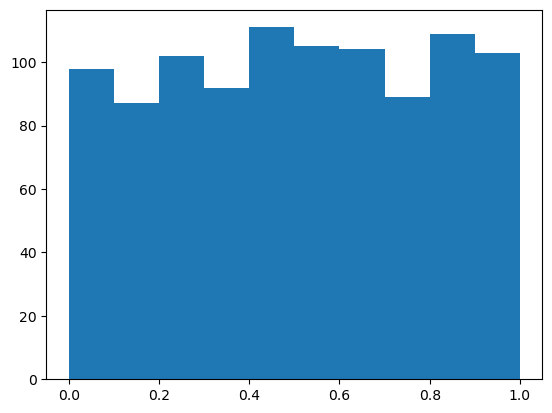

In [33]:
simulations = 100
# create a dataframe to store the results
elasticity = np.random.uniform(0, 1, simulations)
for i in range(simulations):

# plot histogram of elasticity
# plt.hist(elasticity)

In [ ]:
score2012 = compositeInd(sigma=elasticity)